# Phys20762 - Project 3 - Neutron Transport and Scattering Through a Shielding Layer

George Champion - 10824491 <br>
University of Manchester
May 2023

## Intronduction

This experiment aims to test the behavior of neutrons within water, lead and graphite. The mean free path of neutrons in each material is determined as well as the number of neutrons that are absorbed, reflected and transmitted through 10cm slabs. From this the attenuation can be found. Finally, the rates of absoption, reflection and transmition are found when two slabs of different materials are adjacent to each other.

Understanding the bahaviour of neutrons within these materials is very important as all three materials are used as mediums in nuclear fission reactors. Mediums are used to slow fast moving neutrons down, turning them into thermal neutrons so that they are able to reactive with the fissile material.

In [1]:
#Initialisation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kstest
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tnrange


#3x4 array containing the values of absorption, scattering and density for water, lead and
#graphite. 
names = ["Water","Lead", "Graphite"]
physical_constants = np.array([[0.6652, 103.0, 1.00, 18.0153],
                              [0.158, 11.221, 11.35, 207.2],
                              [0.0045, 4.74, 1.67, 12.011]])

N_A = 6.02214076 * 10**23

# Part 1 - Building Tools to Model Neutrons

## Generating a Uniform Distribution

Computers are incapable of generating truly random numbers, hence various different methods have been created in order to generate psudo-random numbers. They often involve performing a complicated calculation on the previous number to generate the next. 

The linear congruential generator (LCG) is a deterministic pseudo-random number generator. The function applied to the previous number to determine the next one is quite simple.
<p style="text-align: center;">$X_{n+1} = (aX_n + c)$ mod $m$,</p>
<br>
$a$, $c$ and $m$ are integers. The initial value is known as the seed. The LCG function used in this report is an adaptation of code provided from the phys20762 week 8-12 supplimentary material. 

The inbuilt numpy.random.uniform function is also deterministic, however it uses an algorithm called a Mersenne Twister to generate the next number. The Mersenne Twister is a far more complex algorithm which vastly reduces the chance of patterns arising compared to an LCG.

Both methods have been used to generate a 1 dimentional array. This has been visualised as a histogram.

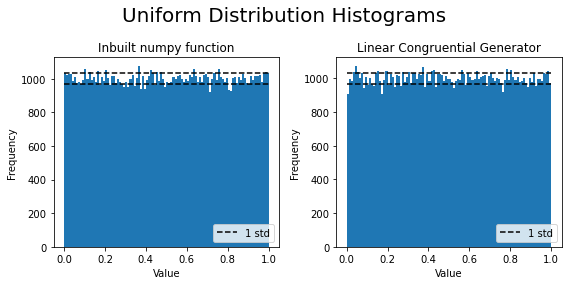

Inbuilt numpy function
One standard deviation 70.0%. Two standard deviations 95.0%
Linear Congruential Generator
One standard deviation 64.0%. Two standard deviations 95.0%


In [2]:
def generate_uniform(in_size):
    '''
    Genertes a unifrom random distribution between 0 and 1 of a given size using the inbuilt
    numpy.random.unifrom function
    
    Parameters:
    -----------
    insize : int
        size of distribution to be generated
    '''
    return np.random.uniform(0, 1, in_size)

def LCG(dimentions, length, x):
    '''
    Genertes a unifrom random distribution between 0 and 1 of a given size using an LCG
    
    Parameters:
    -----------
    dimentions : int
        number of spacial dimentions
    length : int
        number of points
    x : int
        initial seed
    
    Returns
    -------
    array : numpy array
        array containing locations for all points generated
    '''
    #initialises values used 
    m = pow(2, 31)
    a = pow(2, 16) + 3
    c = 0
    
    #iterative process that generates values
    array = np.zeros([dimentions, length])
    for l in range(0, length):
        for k in range(0, dimentions):
            x = np.mod(a*x + c, m)
            array[k, l] = x/m
    
    return array

def plot_histograms(random_array, axis, std, title):
    '''
    Plots histograms and returns the percentage of values that lie within 1 and 2 std's of the
    expected value
    
    Parameters:
    -----------
    random_array : numpy array
        contains randomly generated array
    axis : int
        determines which set of axes will be used
    std : float
        1 standard deviation
    title : string
        name of random number generation used
    
    Returns
    -------
    one_std, two_std : float
        percentage of bins that lie within 1 and 2 standard deviations
    '''
    #Sorts the random numbers into bins and plots a histogram
    bin_counts, _ , _ = ax[axis].hist(random_array, bins=bins, range=[0, 1], density=False)
    ax[axis].plot([0,1],[ex_points_per_bin - std, ex_points_per_bin - std], color = "black",
                  linestyle = "dashed",label = "1 std")
    ax[axis].plot([0,1],[ex_points_per_bin + std, ex_points_per_bin + std], color = "black",
                  linestyle = "dashed")
    ax[axis].set_xlabel('Value')
    ax[axis].set_ylabel('Frequency')
    ax[axis].set_title(title)
    ax[axis].legend(loc = "lower right")
    #ax[axis].set_ylim(800,1100)

    #determines and prints the number of values between one and two standard deviations
    one_std = ((bin_counts >= ex_points_per_bin - std) &
               (bin_counts <= ex_points_per_bin + std)).sum() / len(bin_counts) * 100
    two_std = ((bin_counts >= ex_points_per_bin - 2*std) &
               (bin_counts <= ex_points_per_bin + 2*std)).sum() / len(bin_counts) * 100
    return one_std, two_std

#initiates parameters and calculates the expected standard deviation for a uniform distribution
num_points = 100000
bins = 100
ex_points_per_bin = num_points/bins
std = np.sqrt((ex_points_per_bin*(num_points - ex_points_per_bin))/num_points)

#Initialises a plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Uniform Distribution Histograms",fontsize = 20)
titles = ["Inbuilt numpy function","Linear Congruential Generator"]

#calls histogram plotter
one_std_numpy, two_std_numpy = plot_histograms(generate_uniform(num_points), 0, std,
                                               titles[0])
one_std_LCG, two_std_LCG = plot_histograms(LCG(1, num_points, 123456789)[0], 1, std, titles[1])

#prints results
plt.tight_layout()
plt.show()
print("Inbuilt numpy function")
print("One standard deviation {:.3}%. Two standard deviations {:.3}%".format(one_std_numpy,
                                                                             two_std_numpy))
print("Linear Congruential Generator")
print("One standard deviation {:.3}%. Two standard deviations {:.3}%".format(one_std_LCG,
                                                                             two_std_LCG))


It visually observable that both distributions are uniform. Ontop of this the amount of bins that lie within 1 and 2 standard deviations are close to the expeceted values of 68% and 95% respectively. Therefore, in 1 dimention, both generators are suitable.

## Testing in 3 Dimentions

Both random number generators are suitable for generating a 1d array. However, in this report neutrons are to be modelled in three dimentions.

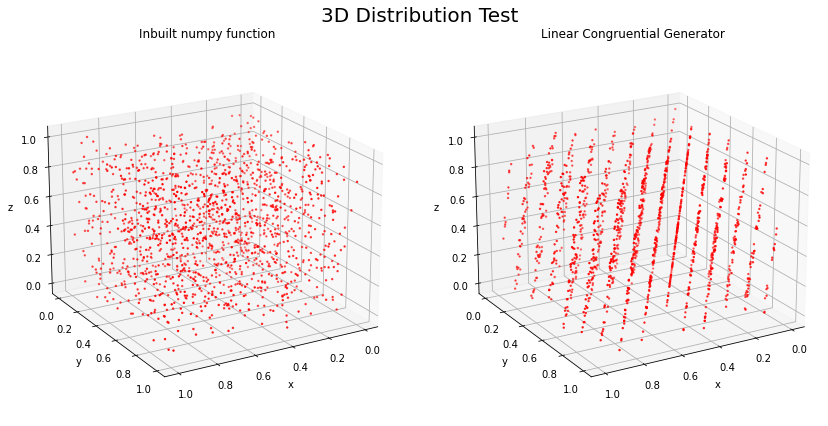

In [3]:
def spectral_issue_test(array, titles, axis):
    '''
    Produces 3d interactive plot of points
    
    Parameters
    ----------
    array : 3D numpy array
        psuedo-random points to be plotted
    titles : string
        titles of plots
    axis : int
        determines which axis points are plotted on
        
    '''
    ax[axis].scatter(array[0, :], array[1, :], array[2, :], color='r', s = 2)
    ax[axis].set_xlabel('x')
    ax[axis].set_ylabel('y')
    ax[axis].set_zlabel('z')
    ax[axis].set_title(titles)
    ax[axis].view_init(20, 60)

#Initialises a plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
fig.suptitle("3D Distribution Test",fontsize = 20)

#calls plotting function for both methods
spectral_issue_test(np.random.uniform(0, 1, size=(3, 1500)), titles[0], 0)
spectral_issue_test(LCG(3, 1500, 123456789), titles[1], 1)
plt.tight_layout()
plt.show()

It is clear to see that the LCG has failed to generate a random 3d distribution. Initially it may seem like the function is repeating itself and generating the same value causing spectral patterns. However this is not the case, this is evident as the spectral patterns are off axis, also the LCG loops back around to itself ater $m$ values. $m$ in our case is $2^{31}$ which is far more than the number of points plotted. Instead, the spectral patterns arise from the simplicity of the algorithm used.

## Generating an Exponential Distribution

In this report, the lengths travelled by neutrons in mediums needs to be determined. The number of neutrons that travel a certain distance drops off exponentially with distance.
<p style="text-align: center;">$I(x) = e^{-x/\lambda}$,</p>
where $\lambda$ is the mean free path. The CDF can be shown through integration to be
<p style="text-align: center;">$cdf(x) = \lambda - \lambda e^{-x/\lambda}$.</p>
The inverse of this is,
<p style="text-align: center;">$cdf^{-1}(x) = -\lambda ln(\lambda - y)$.</p>
For our purposes, the input into the log needs to be a random number between 0 and 1 so this can be simplified to,
<p style="text-align: center;">$s(x) = -\lambda ln(x)$,</p>
where s(x) is our exponential distribution and x is a uniformly distributed random array.

Attenuation in Water = 44.92 ± 0.05cm


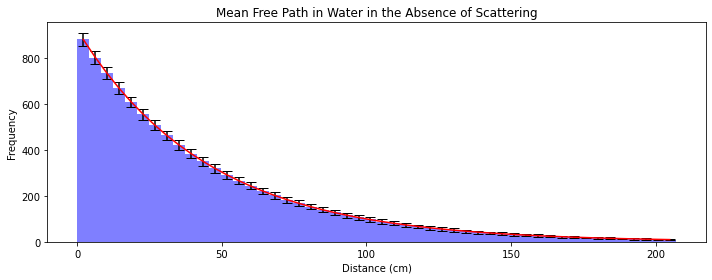

In [4]:
def generate_exponential(mean_free_path, random_array):
    '''
    Maps uniformly distibuted random array to exponentially distributed random array
    
    Parameters
    ----------
    mean_free_path : float
        contains mean free path denoted as lamdba in the notes above
        
    random_array : numpy array
        uniformly distributed random array
    '''
    return -np.log(random_array)*mean_free_path

def mean_and_std(array):
    '''
    Returns the mean and std of a given array
    
    Parameters
    ----------
    array : numpy array
        array of which the mean and std need to be determined
    
    Returns
    -------
    mean : float
    std : float
    '''
    mean = np.mean(array)
    std = np.std(array)
    return mean, std

def find_mean_free_path(mean_free_path, title, in_ax, material):
    '''
    Models an exponential decrease given the mean free path, creates, and returns a calculated
    value of attenuation
    
    Parameters
    ----------
    mean_free_path : float
        mean free path of neutrons given properties of material tested
    '''
    
    #initialises arrays and sets number of bins and histograms to be produced
    num_bins = 50
    loops = 1000
    freqs = np.zeros((loops,num_bins))
    mean_freqs = np.zeros(num_bins)
    std_mean_freqs = np.zeros(num_bins)
    
    #generates first exponential decay to determine the bin edges
    exp_array = generate_exponential(mean_free_path, generate_uniform(10000))
    set_bins = np.histogram_bin_edges(exp_array, bins=num_bins)/2
    
    #generates histograms and stores them in an array
    for i in range(loops):
        exp_array = generate_exponential(mean_free_path, generate_uniform(10000))
        hist, bin_edges = np.histogram(exp_array, bins=set_bins)
        freqs[i] = hist
    
    #determines bin centres and widths
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    widths = np.diff(bin_edges)

    #get means and std on frequencies
    for i in range(num_bins):
        mean_freqs[i], std_mean_freqs[i] = mean_and_std(freqs[:,i])
    
    #gets rid of any indices with 0 points in them
    zero_freq_indices = (mean_freqs == 0)
    mean_freqs = mean_freqs[~zero_freq_indices]
    bin_centers = bin_centers[~zero_freq_indices]
    std_mean_freqs = std_mean_freqs[~zero_freq_indices]
    widths = widths[~zero_freq_indices]
    
    #use polyfit to determine the attenuation and error on attenuation
    p, cov = np.polyfit(bin_centers, np.log(mean_freqs), deg=1, w = 1/std_mean_freqs, cov=True)
    slope = p[0]
    mean_free_path_out = -1/slope
    abs_err = np.sqrt(cov[0][0])/slope**2
    polyfit_y = mean_freqs[0]*np.exp(slope*(bin_centers-widths/2))
    
    #plots histogram with error bars, line of best fit and prints found attenuation
    in_ax.bar(bin_centers, mean_freqs, width=widths, yerr = std_mean_freqs, capsize=5, alpha=0.5,
              color='blue')
    in_ax.set_xlabel('Distance (cm)')
    in_ax.set_ylabel('Frequency')
    in_ax.set_title(title)
    in_ax.plot(bin_centers, polyfit_y, color = "r")
    print("Attenuation in {} = {:.4} \u00B1 {:.1g}cm".format(material, mean_free_path_out 
                                                             ,abs_err))

fig, ax = plt.subplots(1,1, figsize = (10,4))
#calculates the mean free path of water only concidering absorption and passes it to exponential
#plotter
mean_free_path = physical_constants[0,3]/(physical_constants[0,2]
                                          *N_A*physical_constants[0,0])*10**24
find_mean_free_path(mean_free_path, "Mean Free Path in Water in the Absence of Scattering",
                    ax, "Water")
plt.tight_layout()
plt.show()

This function succesfully finds the characteristic attenuation of neutrons in the absence of scattering to be $\approx$ 45. In the absence of scattering the attenutation is the same as the mean free path because if a neutrnon ever collides with any particle it is instantly absorbed.

## Generating Isotropic unit Vectors

As well as needing to provide the neutrons with random path lengths, we also need to provide them with a direction. Each direction should be equally likely to be chosen. If the values of $\theta$ and $\phi$ are uniformly generated then there are an abundance of points at the poles. This can be solved by observing the surface area of the sphere. Taking a triangular section from the equator to the pole, a larger proportion of the surface area of the triangle is at the equator, therefore a proportionally larger number of points need to be generated at lattitides closer to the equator.

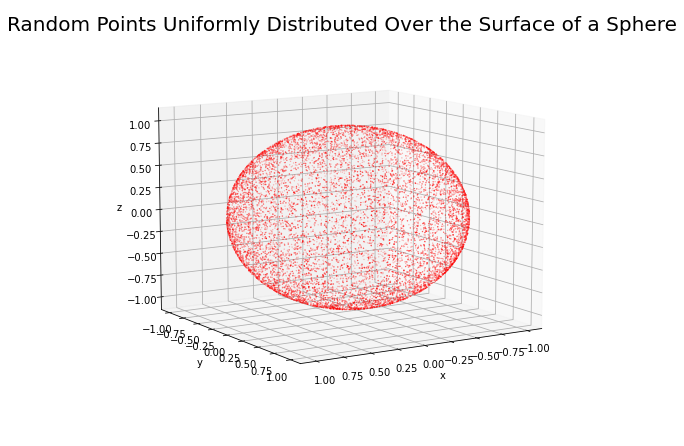

In [5]:
def generate_vector(insize):
    '''
    Generates x, y and z values producing an isotropic spherical distribution
    
    Parameters
    ----------
    insize : int
        number of points
    
    Returns
    -------
    numpy array
        3d array containing the coordinates for each point
    '''
    uniform = generate_uniform(insize)
    theta = np.arccos(1 - 2*uniform)
    phi = np.random.uniform(low=0.0, high=(2*np.pi), size=insize)
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    
    return np.column_stack((x, y, z))

#calls function that generates unit vectors
isotropic_array = generate_vector(10000)

#plots 
fig = plt.figure(figsize = (6,6))
fig.suptitle("Random Points Uniformly Distributed Over the Surface of a Sphere",fontsize = 20)
ax = Axes3D(fig)
ax.scatter(isotropic_array[:,0], isotropic_array[:,1], isotropic_array[:,2], color='r',s = 0.1)
ax.view_init(10, 58)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Isotropic Vectors at Exponentially Distributed Lengths

Finally, the exponential length function and isotropic ditribution functions need to be combined in order to simulate a neutron being scattered and travelling a random distance in a random direction. To do this 250 neutrons will be simulated travelling out from the origin. The attenuation water in the absence of scattering has been used to determine distances.

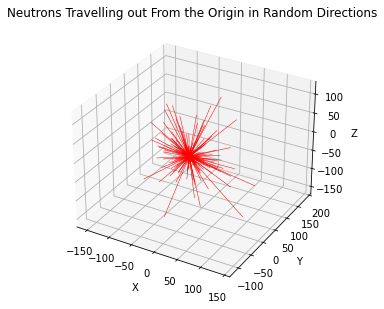

In [6]:
#initialises the number of neutrons simulated and finds the mean free path in water
num_neutrons = 250
mean_free_path = physical_constants[0,3]/(physical_constants[0,2]
                                          *N_A*physical_constants[0,0])*10**24

#calls the distance and vector functions to calculate the end positions
distances = np.array([generate_exponential(mean_free_path, generate_uniform(num_neutrons))])
direction_vectors = generate_vector(num_neutrons)
end_positions = np.transpose(distances)*direction_vectors

#Initialises plot and plots a line from the origin to the end position of each point
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection='3d')

for i in range(num_neutrons):
    ax.plot([0, end_positions[i, 0]], [0, end_positions[i, 1]], [0, end_positions[i, 2]],
            color='r', linewidth = 0.5)

ax.set_title("Neutrons Travelling out From the Origin in Random Directions")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
    

The two functions have worked in conjunction with one another to sucessfully generate the paths of neutrons travelling out from the origin.

# Part 2 - Modelling Neutrons Travelling Through Water, Lead and Graphite

## Macroscopic Cross Sections

The macroscopic cross section $\sum$ of scattering and absorption can be found as follows:

<p style="text-align: center;">$\sum = \frac{\rho N_a \sigma}{M}$,</p>
where $\rho$ is the density, $\sigma$ is the microscopic cross section, $M$ is the molar mass and $N_a$ is avagadros constant.

In [7]:
micro_absorption = physical_constants[:,0]
micro_scattering = physical_constants[:,1]

#applying the function above to the microscopic cross sections
macro_absorption = physical_constants[:,2]*N_A*micro_absorption/physical_constants[:,3]/10**24
macro_scattering = physical_constants[:,2]*N_A*micro_scattering/physical_constants[:,3]/10**24

#plotting a table of the data
table = {'Material': names, 'Microscopic Absorption': micro_absorption, 'Macroscopic Absorption':
         macro_absorption, 'Microscopic Scattering': micro_scattering, 'Macroscopic Scattering':
         macro_scattering}
df = pd.DataFrame(table)
styled = df.style.set_table_styles([{'selector': 'td',
                                      'props': [('border', '1px solid black')]}]).hide_index()
display(styled)

Material,Microscopic Absorption,Macroscopic Absorption,Microscopic Scattering,Macroscopic Scattering
Water,0.665200,0.022236,103.000000,3.443076
Lead,0.158000,0.005212,11.221000,0.370159
Graphite,0.004500,0.000377,4.740000,0.396887


## Determining the Mean Free Path of Neutrons in Each Material

The mean free path in each material will be determined. The histogram plotting function used to determine the mean free path in water in the absence of scattering can once again be used.

Attenuation in Water = 0.2885 ± 0.0004cm
Attenuation in Lead = 2.67 ± 0.003cm
Attenuation in Graphite = 2.515 ± 0.003cm


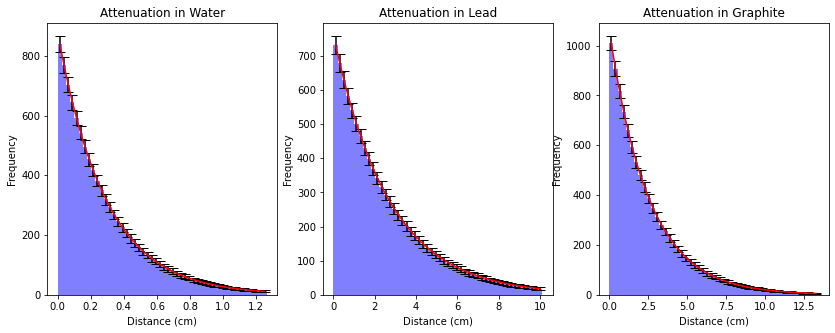

In [8]:
fig, ax = plt.subplots(1,3, figsize = (14,5))

#calling the mean_free_path function created earlier for each material
for i, material in enumerate(physical_constants):
    mean_free_path = material[3]/(material[2]*N_A*(material[0]+material[1]))*10**24
    find_mean_free_path(mean_free_path, "Attenuation in {}".format(names[i]), ax[i], names[i])   

Water has a much smaller mean free path than lead and graphite. This is expected as the cross section of water is much greater than lead and graphite.

## Visualisation of Random Walks of Particles

In this section a few particles will be simulated entering a block of thickness 10cm. The x, y and z positions will be simulated until they either are absorbed, transmitted or reflected.

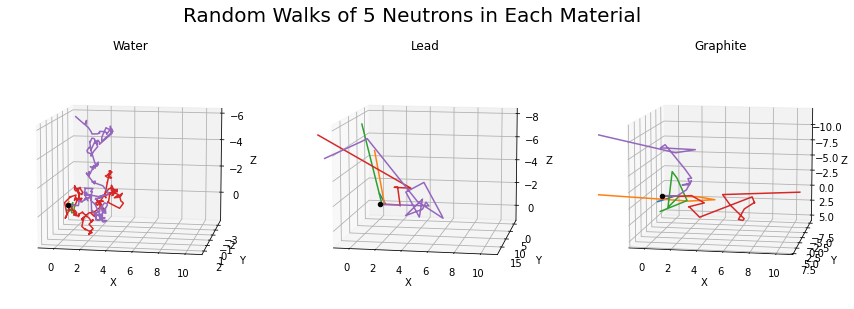

In [9]:
def random_walk(material, axis):
    '''
    Generates the x, y, and z coordinates of random walks of 5 neutrons given the properties of
    the material.

    Parameters
    ----------
    material : array
        contains the mass, density, and cross sections of the material
    axis : int
        axis that the points will be plotted on

    Returns
    -------
    finished_neutrons : list of 2D numpy arrays
        list containing 2D numpy arrays of different lengths that hold path histories of neutrons

    '''
    # Initializes arrays and sets mean free path value and absorption probability
    active_neutrons = [np.zeros((1, 3)) for _ in range(5)]
    finished_neutrons = []
    mean_free_path = material[3] / (material[2] * N_A * (material[0] + material[1])) * 10 ** 24
    absorb_prob = material[0] / (material[0] + material[1])

    # Generates first path which is perpendicular to the x plane
    distances = generate_exponential(mean_free_path, generate_uniform(5))
    active_neutrons = [np.concatenate((neutron_positions, np.array([[distances[i], 0, 0]])))
                       for i,neutron_positions in enumerate(active_neutrons)]

    # Iterated constant that represents how many collisions have taken place
    j = 1

    # Iterates when there are still active neutrons
    while len(active_neutrons) > 0:

        # Generates an array determining which neutrons are absorbed and which are scattered
        absorb_array = generate_uniform(len(active_neutrons))

        # Finds the indices of the neutrons that need to be removed
        indices_to_remove = [
            i for i, neutron_positions in enumerate(active_neutrons) if
            ((neutron_positions[j, 0] >= 0) & (neutron_positions[j, 0] <= 10) &
             (absorb_array[i] < absorb_prob)) |
            (neutron_positions[j, 0] < 0) |
            (neutron_positions[j, 0] > 10)
        ]

        # Removes finished neutrons from active_neutrons and adds them to finished_neutrons
        finished_neutrons.extend([active_neutrons[index] for index in indices_to_remove])
        active_neutrons = [neutron_positions for i, neutron_positions in enumerate
                           (active_neutrons)if i not in indices_to_remove]

        # Finds the next positions of the neutrons
        translation = np.transpose([generate_exponential(mean_free_path, generate_uniform(len(
            active_neutrons)))]) * generate_vector(len(active_neutrons))
        active_neutrons = [np.concatenate((neutron_positions, np.array(
            [[neutron_positions[j, 0] + translation[i, 0], neutron_positions[j, 1]
              + translation[i, 1], neutron_positions[j, 2] + translation[i, 2]]])))
                           for i, neutron_positions in enumerate(active_neutrons)]

        # Iterates to the next step
        j += 1

    return finished_neutrons


#initialises plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})
fig.suptitle("Random Walks of 5 Neutrons in Each Material",fontsize = 20)

#calls random walk plotter for each material
for i, material in enumerate(physical_constants):
    neutron_paths = random_walk(material, ax[i])
    ax[i].scatter(0,0,0, color = "black")
    for j, path in enumerate(neutron_paths):
        ax[i].plot(path[:,0], path[:,1], path[:,2])
        ax[i].set_xlim([-1, 11])
        ax[i].set_xlabel('X')
        ax[i].set_ylabel('Y')
        ax[i].set_zlabel('Z')
        ax[i].view_init(-170, -100)
        ax[i].set_title(names[i])

plt.show()

Each individual section of the random walk in water is very small demonstrating how neutrons do not travel far before they collide with a water molecule. This confirms the small mean free path value found in the previous section. On top of this, neutrons have the lowest attenuation in water. This can be seen as the neutrons penetrate deeper into lead and graphite.

## Determining Absorption, Reflection and Transmition Rates into 10cm Thick Materials

Now the absorption, reflection and transmition rates of neutrons through 10cm of each material will be determined. 10,000 neutrons will simulated 10 times in each material. The neutrons are only simulated to move in the x direction as the slabs are simulated to be infinite in the y and z dimentions. A new function x_translation has been made, this combines the functions of generate_exponential and generate_vector. To save computational power the x vector is being calculated as if it were the z vector in the previous generate_vector function. This is as z is only dependant on $\theta$ and not $\phi$ so only one unifrom array needs to be generated. 

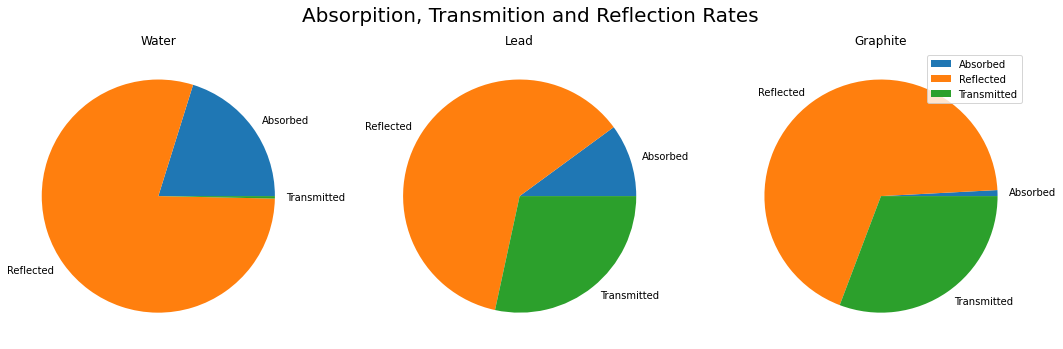

Material,Absorbed %,Reflected %,Transmitted %
Water,20.2 ± 0.4,79.5 ± 0.4,0.343 ± 0.03
Lead,10.1 ± 0.2,61.5 ± 0.4,28.4 ± 0.3
Graphite,0.825 ± 0.08,68.4 ± 0.4,30.8 ± 0.4


In [10]:
def x_translation(num_neutrons, mean_free_path):
    '''
    The generate_exponential and generate_vector functions have been combined outputting the
    translation in x
    
    Parameters
    ----------
    num_neutrons : int
        number of neutrons
    mean_free_path : float
        mean free path in material
        
    Returns
    -------
    1d array containing the x translations of each neutron
    '''
    return -np.cos(np.arccos(1 - 2*np.random.uniform(0,1,num_neutrons))
                  )*np.log(np.random.uniform(0,1,num_neutrons))*mean_free_path

def find_end_states(length, material):
    '''
    For a particular length and material this determines the percentage of neutrons that are
    absorbed, reflected and transmitted.
    
    Paramaters
    ----------
    length : float
        length of material
        
    material_constants : numpy array
        1d array containing mass, density and cross sections of material
    '''
    #initialises counters and constants specific to the material
    num_neutrons = 10000
    num_reflected = 0
    num_transmitted = 0
    num_absorbed = 0
    cross_section = material[0] + material[1]
    absorb_prob = material[0]/cross_section
    mean_free_path = material[3]/(material[2]*N_A*cross_section)*10**24
    
    #generates first step perpendicular to x plane
    neutron_x_pos = generate_exponential(mean_free_path, generate_uniform(num_neutrons))
    
    #while there are still neutrons that need to be simulated
    while len(neutron_x_pos)>0:
        
        #increases the number reflected and transmitted
        num_reflected += np.count_nonzero(neutron_x_pos < 0)
        num_transmitted += np.count_nonzero(neutron_x_pos > length)
        
        #generates a uniform random array to simulate absorption and adds absorbed neutrons
        absorb_array = generate_uniform(len(neutron_x_pos))
        num_absorbed += np.count_nonzero((neutron_x_pos > 0) & (neutron_x_pos < length)
                                         & (absorb_array < absorb_prob))
        
        #deleted finished neutrons
        neutron_x_pos = np.delete(neutron_x_pos, np.where(
            (neutron_x_pos >= 0) & (neutron_x_pos <= length) & (absorb_array < absorb_prob) | 
            (neutron_x_pos < 0) | (neutron_x_pos > length)))
    
        #determined new position
        neutron_x_pos = neutron_x_pos + x_translation(len(neutron_x_pos), mean_free_path)
        
    return num_absorbed/100, num_reflected/100, num_transmitted/100

#initialises plots and table
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Absorpition, Transmition and Reflection Rates",fontsize = 20)
labels = ["Absorbed", "Reflected", "Transmitted"]
absorbed_array = np.zeros(10)
transmitted_array = np.zeros(10)
reflected_array = np.zeros(10)
table_absorbed = np.empty(3,dtype = object)
table_reflected = np.empty(3,dtype = object)
table_transmitted = np.empty(3,dtype = object)

#calls simulation function for each material and prints results
for i, material in enumerate(physical_constants):
    for j in range(10):
        absorbed_array[j], reflected_array[j], transmitted_array[j] = find_end_states(10, material)
    mean_absorbed, std_absorbed = mean_and_std(absorbed_array)
    mean_reflected, std_reflected = mean_and_std(reflected_array)
    mean_transmitted, std_transmitted = mean_and_std(transmitted_array)
    ax[i].pie([mean_absorbed, mean_reflected, mean_transmitted], labels = labels)
    ax[i].set_title(names[i])
    
    #formats and adds calculated values to table arrays
    table_absorbed[i] = ("{:.3} \u00B1 {:.1}".format(mean_absorbed, std_absorbed))
    table_reflected[i] = ("{:.3} \u00B1 {:.1}".format(mean_reflected, std_reflected))
    table_transmitted[i] = ("{:.3} \u00B1 {:.1}".format(mean_transmitted, std_transmitted))

    
plt.tight_layout()
plt.legend()
plt.show()

#Generates and displays the table
table = {'Material': names, 'Absorbed %': table_absorbed, 'Reflected %': table_reflected,
         'Transmitted %': table_transmitted}
df = pd.DataFrame(table)
styled = df.style.set_table_styles([{'selector': 'td',
                                      'props': [('border', '1px solid black')]}]).hide_index()
display(styled)

## Determining Attenuation

To determine the attenuation the number of neutrons that are transmitted is found for lengths from 1cm to 20cm. The log of the number of neutrons transmitted should provide a linear fit where -1/gradient will be the attenuation. 

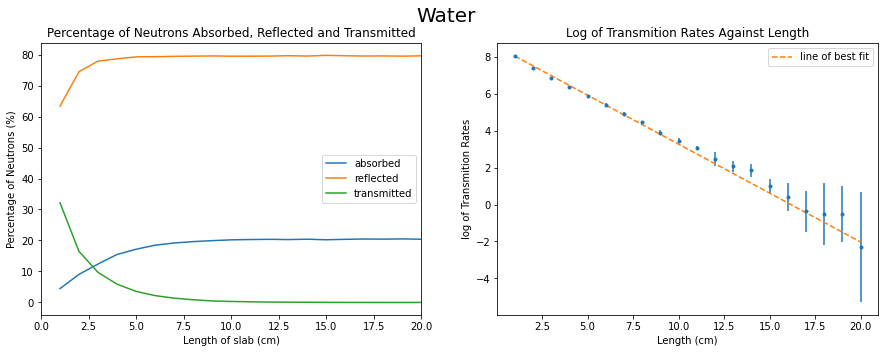

Attenuation = 1.89 ± 0.03 cm
The reduced chi squared value on this fit is: 3.368


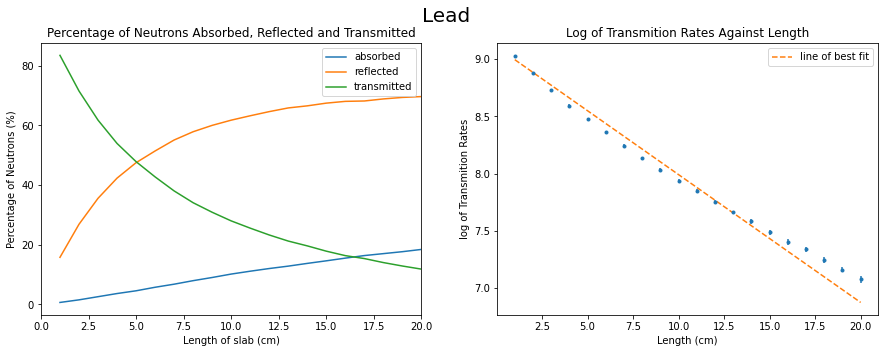

Attenuation = 8.96 ± 0.2 cm
The reduced chi squared value on this fit is: 32.24


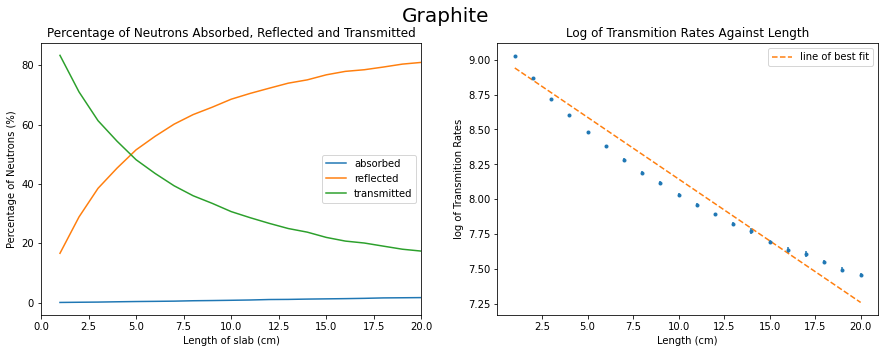

Attenuation = 11.3 ± 0.5 cm
The reduced chi squared value on this fit is: 104.1


In [11]:
def find_attenuation(material, lengths):
    '''
    Utilises the find_end_states function for a given material over a given set of lengths to
    determine the attenuation and plots relevent graphs
    
    Parameters
    ----------
    material : numpy array
        contains proporties of the material
    lengths : numpy array
        lenths to be tested over
    '''
    #initialises empty arrays to store mean and error values for each length
    absorbed_means = np.zeros((20))
    absorbed_errors = np.zeros((20))
    reflected_means = np.zeros((20))
    reflected_errors = np.zeros((20))
    transmitted_means = np.zeros((20))
    transmitted_errors = np.zeros((20))
    
    #iterates through each length
    for i, length in enumerate(lengths):
        absorbed_array = np.zeros(10)
        transmitted_array = np.zeros(10)
        reflected_array = np.zeros(10)
        #calls find_end_states function 10 times for each length
        for j in range(10): 
            num_absorbed, num_reflected, num_transmitted = find_end_states(length,material)
            absorbed_array[j] = num_absorbed
            reflected_array[j] = num_reflected
            transmitted_array[j] = num_transmitted
        #means and std's of each length are stored
        absorbed_means[i], absorbed_errors[i] = mean_and_std(absorbed_array)
        reflected_means[i], reflected_errors[i] = mean_and_std(reflected_array)
        transmitted_means[i], transmitted_errors[i] = mean_and_std(transmitted_array)
    
    #plots and formats graph of neutron end states as length increases
    ax[0].set_title("Percentage of Neutrons Absorbed, Reflected and Transmitted")
    ax[0].set_xlabel("Length of slab (cm)")
    ax[0].set_ylabel("Percentage of Neutrons (%)")
    ax[0].plot(lengths, absorbed_means, label="absorbed")
    ax[0].plot(lengths, reflected_means, label="reflected")
    ax[0].plot(lengths, transmitted_means, label="transmitted")
    ax[0].legend()
    ax[0].set_xlim(0,20)
    
    #any terms where the error is 0 are removed from the fitting process
    delete_indices = np.where(transmitted_errors == 0)
    transmitted_errors = np.delete(transmitted_errors, delete_indices)
    lengths = np.delete(lengths, delete_indices)
    transmitted_means = np.delete(transmitted_means, delete_indices)
    
    #finds the log of the means and the error on the logs
    log_of_means = np.log(transmitted_means*100)
    log_error = (transmitted_errors/transmitted_means)
    
    #uses polyfit to determine the attenuation coefficient and error
    p, cov = np.polyfit(lengths, log_of_means, w = 1/log_error, deg = 1, cov = True)
    slope = p[0]
    attenuation = -1/slope
    abs_err = np.sqrt(cov[0][0])/slope**2
    
    #plots graph of attenuation coefficient fitting
    ax[1].set_title("Log of Transmition Rates Against Length")
    ax[1].set_xlabel("Length (cm)")
    ax[1].set_ylabel("log of Transmition Rates")
    ax[1].errorbar(lengths, log_of_means, log_error, fmt = 'o', markersize = 3)
    ax[1].plot(lengths, p[0]*lengths+p[1], linestyle = "dashed", label="line of best fit")
    ax[1].legend()
    
    plt.show()
       
    #calculates the reduced chi sqared value of each fit and prints the results
    reduced_chi = reduced_chi_squared(log_of_means, p[0]*lengths+p[1], log_error)
    print("Attenuation = {:.3} \u00B1 {:.1} cm".format(attenuation, abs_err))
    print("The reduced chi squared value on this fit is: {:.4}".format(reduced_chi))
    
    return(transmitted_means)

def reduced_chi_squared(found_points, expected_points, errors):
    """
    Calculate the reduced chi-squared value for the fitting of found points to expected points.

    Parameters
    ----------
    found_points : numpy array
        Array of found points
    expected_points : numpy array
        Array of expected points.
    errors : numpy array
        Array of errors associated with the found points.

    Returns
    -------
    float: The reduced chi-squared value.
    """
    residuals = found_points - expected_points
    chi_squared = np.sum((residuals / errors) ** 2)
    degrees_of_freedom = len(found_points) - 1
    reduced_chi_squared = chi_squared / degrees_of_freedom
    return reduced_chi_squared

#defines lengths array
lengths = np.linspace(1,20,20)

#iterates through each material calling the find attenuation function
for i, material in enumerate(physical_constants):
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    fig.suptitle(names[i],fontsize = 20)
    test = find_attenuation(material, lengths)

Observing all of the chi squared values and the graphs it is clear to see that the decreasing exponential model used to determine the attenuation length is not accurate for this number of neutrons. This can be seen as the logarithmic graphs are not linear.

## Woodcock Method

The woodcock method is a different method that can be used when the mean free path is not constant. It works by simulating each neutron to have the mean free path of the material with the greatest cross section. At the end of each step, if the neutron is in the material with the smaller cross section there will be a chance that the neutron does not interact at all. This is known as a fictitious step. 

To test if it works it will be tested in a system where we already know what the results should be. The 10cm lead slab will be used as a contol as a large number of neutrons finish in each state. The systems tested will be: 10cm of lead and then 10cm of a vacuum, 10cm of a vacuum and then 10cm of lead and two 5cm lead slabs. 

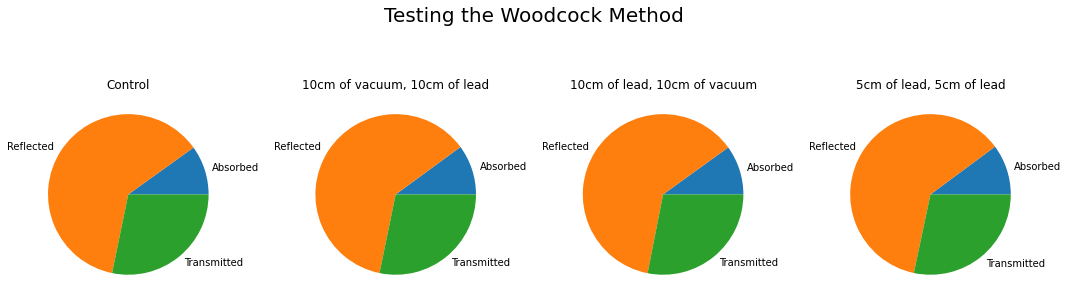

Run,Absorbed %,Reflected %,Transmitted %
Control,9.92 ± 0.4,61.8 ± 0.3,28.2 ± 0.2
"10cm of vacuum, 10cm of lead",10.1 ± 0.4,61.7 ± 0.6,28.2 ± 0.5
"10cm of lead, 10cm of vacuum",9.95 ± 0.3,62.0 ± 0.3,28.1 ± 0.4
"5cm of lead, 5cm of lead",10.1 ± 0.3,61.5 ± 0.4,28.3 ± 0.4


In [12]:
def generate_direction(insize):
    '''
    generates x component of isotropic unit vector
    
    Parameters
    ----------
    insize : int
        size of array to output
    
    Returns
    -------
    array of x components of isotropic unit vectors
    '''
    return np.cos(np.arccos(1 - 2*generate_uniform(insize)))

def woodcock(material_1, material_2, length_1, length_2):
    '''
    Simulates neutrons passing into a system where two materials are next to eacho ther, it 
    determines the number of neutrons absorbed reflected and transmitted
    
    Parameters
    ----------
    material_1 : numpy array
        array containing the physical proporties of material 1
    material_2 : numpy array
        array containing the physical proporties of material 2        
    length_1 : int
        length of section 1
    length_2 : int
        length of section 2
    '''
    #initialises counters
    num_neutrons = 10000
    num_reflected = 0
    num_transmitted = 0
    num_absorbed = 0
    
    #calculated cross section of each material
    cross_section_1 = material_1[0] + material_1[1]
    cross_section_2 = material_2[0] + material_2[1]
    
    #sets mean free path, absorption probabilities and real probability of each section dependant 
    #on which section has the larger cross section
    if (cross_section_1 >= cross_section_2):
        mean_free_path = material_1[3]/(material_1[2]*N_A*cross_section_1)*10**24
        real_prob = cross_section_2/cross_section_1
        small_mfp_absorb_prob = material_1[0]/cross_section_1
        large_mfp_absorb_prob = material_2[0]/cross_section_2
        small_mfp_start = 0
        small_mfp_end = length_1
        large_mfp_start = length_1
        large_mfp_end = length_1 + length_2
    
    else:
        mean_free_path = material_2[3]/(material_2[2]*N_A*cross_section_2)*10**24
        real_prob = cross_section_1/cross_section_2
        small_mfp_absorb_prob = material_2[0]/cross_section_2
        large_mfp_absorb_prob = material_1[0]/cross_section_1
        small_mfp_start = length_1
        small_mfp_end = length_1 + length_2
        large_mfp_start = 0
        large_mfp_end = length_1
    
    #initialises length array, neutron positions and direction array as ones as first step is in 
    #x direction
    directions_array = np.ones(num_neutrons)
    length_array = generate_exponential(mean_free_path, generate_uniform(num_neutrons))
    neutron_x_pos = np.zeros(num_neutrons)
            
    #while there are still neutrons to simulate
    while len(neutron_x_pos)>0:
            
        #finds new positions
        neutron_x_pos = neutron_x_pos + directions_array*length_array
        
        #counts number reflected and transmitted
        num_reflected += np.count_nonzero(neutron_x_pos < 0)
        num_transmitted += np.count_nonzero(neutron_x_pos > 20)
                
        #generates arrays to determine if neutrons are absobed in each material and if they are
        #fictitious
        small_mfp_absorb_array = generate_uniform(len(neutron_x_pos))
        large_mfp_absorb_array = generate_uniform(len(neutron_x_pos))
        fictitious_array = generate_uniform(len(neutron_x_pos))
        
        #adds up absorbed neutrons if they are in a certain section, have been absorbed and are
        #real
        num_absorbed += len(np.where((neutron_x_pos > small_mfp_start) &
                                     (neutron_x_pos < small_mfp_end) &
                                     (small_mfp_absorb_array < small_mfp_absorb_prob))[0])
        num_absorbed += len(np.where((neutron_x_pos > large_mfp_start) &
                                     (neutron_x_pos < large_mfp_end) &
                                     (large_mfp_absorb_array < large_mfp_absorb_prob) &
                                     (fictitious_array < real_prob))[0])
            
        #finds indices of neutrons that are in the section with the smaller mfp and havnt been
        #absorbed or in the section with the larger mfp and are real and havnt been absorbed
        new_direction_indices = (np.where(((neutron_x_pos > small_mfp_start) &
                                          (neutron_x_pos < small_mfp_end) &
                                          (small_mfp_absorb_array > small_mfp_absorb_prob)) |
                                         ((neutron_x_pos > large_mfp_start) &
                                          (neutron_x_pos < large_mfp_end) &
                                          (fictitious_array < real_prob) &
                                          (large_mfp_absorb_array > large_mfp_absorb_prob))))[0]
        
        #generates new directions
        new_directions = generate_direction(len(new_direction_indices))
                
        #applies new directions to appropriete neutrons       
        directions_array[new_direction_indices] = new_directions

        
        #finds indices of neutrons that have left the material or have been absorbed in either
        #section
        delete_indices = np.where((neutron_x_pos < 0) | (neutron_x_pos > 20) |
                                  ((neutron_x_pos >= small_mfp_start) &
                                   (neutron_x_pos <= small_mfp_end) &
                                   (small_mfp_absorb_array < small_mfp_absorb_prob)) |
                                  ((neutron_x_pos > large_mfp_start) &
                                   (neutron_x_pos <= large_mfp_end) &
                                   (fictitious_array < real_prob) &
                                   (large_mfp_absorb_array < large_mfp_absorb_prob)))
        
        #deletes indices from directions array and positions array
        directions_array = np.delete(directions_array, delete_indices)
        neutron_x_pos = np.delete(neutron_x_pos, delete_indices)
        
        #generates all new lengths based on smaller mean free path
        length_array = generate_exponential(mean_free_path, generate_uniform(len(neutron_x_pos)))
        
    return num_absorbed/100, num_reflected/100, num_transmitted/100

#initialises physical parameters of vacuum very small values have been used as cross sections to
#avoid dividing by zero
vacuum = [10**(-30), 10**(-30), 1, 1]

#initialises plots and table
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle("Testing the Woodcock Method",fontsize = 20)
titles = ["Control", "10cm of vacuum, 10cm of lead", "10cm of lead, 10cm of vacuum", "5cm of lead, 5cm of lead"]
absorbed_array = np.zeros(10)
transmitted_array = np.zeros(10)
reflected_array = np.zeros(10)
table_absorbed = np.empty(4,dtype = object)
table_reflected = np.empty(4,dtype = object)
table_transmitted = np.empty(4,dtype = object)

#loops 10 times to simulate 10cm of lead using old method
for j in range(10):
    absorbed_array[j], reflected_array[j], transmitted_array[j] = find_end_states(10, physical_constants[1])

#finds means and erros, plots pie chart and append values to table array
mean_absorbed, std_absorbed = mean_and_std(absorbed_array)
mean_reflected, std_reflected = mean_and_std(reflected_array)
mean_transmitted, std_transmitted = mean_and_std(transmitted_array)
ax[0].pie([mean_absorbed, mean_reflected, mean_transmitted], labels = labels)
ax[0].set_title(titles[0])
table_absorbed[0] = ("{:.3} \u00B1 {:.1}".format(mean_absorbed, std_absorbed))
table_reflected[0] = ("{:.3} \u00B1 {:.1}".format(mean_reflected, std_reflected))
table_transmitted[0] = ("{:.3} \u00B1 {:.1}".format(mean_transmitted, std_transmitted))

#creates list of test parameters to iterate through using the woodcock method
parameters = [[vacuum, physical_constants[1], 10, 10], [physical_constants[1], vacuum, 10, 10],
              [physical_constants[1], physical_constants[1], 5, 5]]

#loops through each individual test using the woodcock method to find absorption, reflection and
#transmition
for i, test in enumerate(parameters):
    for j in range(10):
        absorbed_array[j], reflected_array[j], transmitted_array[j] = woodcock(test[0],test[1],
                                                                               test[2],test[3])
    #finds means and errors and plots pie chart and adds values to table array
    mean_absorbed, std_absorbed = mean_and_std(absorbed_array)
    mean_reflected, std_reflected = mean_and_std(reflected_array)
    mean_transmitted, std_transmitted = mean_and_std(transmitted_array)
    ax[i+1].pie([mean_absorbed, mean_reflected, mean_transmitted], labels = labels)
    ax[i+1].set_title(titles[i+1])
    table_absorbed[i+1] = ("{:.3} \u00B1 {:.1}".format(mean_absorbed, std_absorbed))
    table_reflected[i+1] = ("{:.3} \u00B1 {:.1}".format(mean_reflected, std_reflected))
    table_transmitted[i+1] = ("{:.3} \u00B1 {:.1}".format(mean_transmitted, std_transmitted))

plt.tight_layout()
plt.show()

#Generates and displays the table
table = {'Run': titles, 'Absorbed %': table_absorbed, 'Reflected %': table_reflected, 'Transmitted %': table_transmitted}
df = pd.DataFrame(table)
styled = df.style.set_table_styles([{'selector': 'td',
                                      'props': [('border', '1px solid black')]}]).hide_index()
display(styled)

As displayed in the pie charts and the tables, all four methods produce results that are within tolerance of each other.

## Transmition Rates Through Two Different 10cm Slabs

Now the woodcock method will be used to determine the absorbtion, reflection and transmition rates through combinations 10cm slabs of each material.

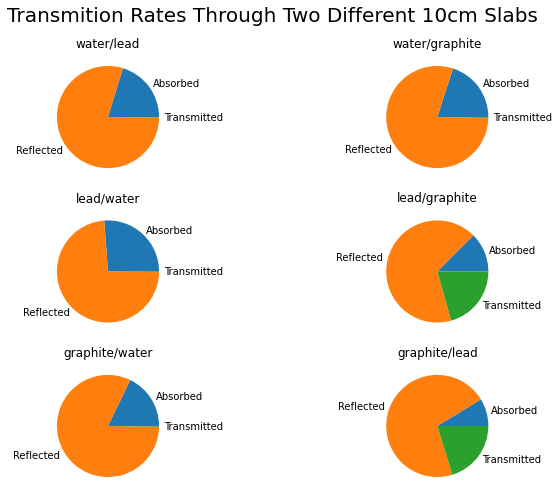

Slabs,Absorbed %,Reflected %,Transmitted %
water/lead,20.3 ± 0.4,79.6 ± 0.4,0.159 ± 0.04
water/graphite,20.0 ± 0.3,79.7 ± 0.3,0.266 ± 0.04
lead/water,26.2 ± 0.5,73.6 ± 0.5,0.19 ± 0.03
lead/graphite,12.5 ± 0.3,66.9 ± 0.4,20.6 ± 0.3
graphite/water,17.8 ± 0.3,81.9 ± 0.3,0.25 ± 0.07
graphite/lead,8.71 ± 0.2,71.1 ± 0.3,20.2 ± 0.3


In [14]:
#figure, final value arrays and table arrays are initialised
fig, ax = plt.subplots(3, 2, figsize=(10, 7))
fig.suptitle("Transmition Rates Through Two Different 10cm Slabs",fontsize = 20)
titles = ["water/lead","water/graphite","lead/water","lead/graphite","graphite/water",
          "graphite/lead"]
absorbed_array = np.zeros(10)
transmitted_array = np.zeros(10)
reflected_array = np.zeros(10)
table_absorbed = np.empty(6,dtype = object)
table_reflected = np.empty(6,dtype = object)
table_transmitted = np.empty(6,dtype = object)

#row index is made for ease of plotting
row = 0

#loops through each material being material 1
for i,material_1 in enumerate(physical_constants):
    #loops through each material being material 2
    for j, material_2 in enumerate(physical_constants):
        #only runs if it isnt the same material twice
        if i != j:
            
            if i < j:
                #reqired to change plots from 3x3 to 3x2
                j -= 1
            
            #loops 10 times calling woodcock method for specific materials
            for k in range(10):
                absorbed_array[k], reflected_array[k], transmitted_array[k] = woodcock(material_1,
                                                                                       material_2,
                                                                                       10,10)
            #finds means and errors and plots pie chart and adds values to table array
            mean_absorbed, std_absorbed = mean_and_std(absorbed_array)
            mean_reflected, std_reflected = mean_and_std(reflected_array)
            mean_transmitted, std_transmitted = mean_and_std(transmitted_array)
            ax[i,j].pie([mean_absorbed, mean_reflected, mean_transmitted], labels = labels)
            ax[i,j].set_title(titles[row])
            table_absorbed[row] = ("{:.3} \u00B1 {:.1}".format(mean_absorbed, std_absorbed))
            table_reflected[row] = ("{:.3} \u00B1 {:.1}".format(mean_reflected, std_reflected))
            table_transmitted[row] = ("{:.3} \u00B1 {:.1}".format(mean_transmitted,
                                                                  std_transmitted))
            
            row += 1
                
plt.tight_layout()
plt.show()

#Generates and displays the table
table = {'Slabs': titles, 'Absorbed %': table_absorbed, 'Reflected %': table_reflected,
         'Transmitted %': table_transmitted}
df = pd.DataFrame(table)
styled = df.style.set_table_styles([{'selector': 'td',
                                      'props': [('border', '1px solid black')]}]).hide_index()
display(styled)
    

## Results of interest

As expected the lead/graphite and graphite/lead slabs transmit the most neutrons. This is due to water having the greatest absorption and scattering cross sections.

Water/lead has a greater reflection rate and a lower absorption rate than lead/water, this is as the absorption cross section makes up a greater component of the total cross section in lead than in water.

The absorption and reflection rates for water/lead and water/graphite are within error of each other. This demonstrates how when water is the first material it dominates as $\approx$99.97% of neutrons are absorbed or reflected by a 10cm thick slab of water.

## Application in Nuclear Fission Reactors

It is the moderators roll in a reactor to slow down the neutrons, this is done through scattering collisions. All three materials have high scattering cross sections, this can be seen as in every pie chart the largest section is reflection. This demonstrates that the particles have a low mean free path and low absorption rate, hence they do not travel far before they scatter.

Water moderated reactors operate at low temperatures relative to graphite and lead moderated reactors. This is as water is be used as a coolant as well as a moderator and water can not exceed 100$^{\circ}$C.

Graphite moderated reactors operate at far higher temperatures. Graphite is suited to this as it is very chemically stable.

Finally, lead is used as a moderator in fast neutron reactors. In such reactors neutrons have a much greater kinetic energy, however moderation is still required. Fast reactors utilise more types of fuel that have a lower enrichment level and hence reduce nuclear waste.